# Term Paper

### Part 1

In [2]:
import pandas as pd
import glob as glob

In [11]:
files=glob.glob(f'data/SCE-*-20*.csv')

df_list=[]

waves_number=0

#Loop to read in and append files
for file in files:
    df=pd.read_csv(file,sep=";",parse_dates=['date'])
    df_list.append(df)


sce_df=pd.concat(df_list,ignore_index=True)

# Evaluating unique individuals inside the dataframe 
unique_individuals = sce_df['userid'].nunique() 

# Userid column contains unique identifiers for individuals
print(f"Number of unique individuals: {unique_individuals}")

# Number of rows in the DataFrame 
num_rows = sce_df.shape[0]
print(f"Number of rows in the DataFrame: {num_rows}")

# Setting date as index and sorting
sce_df.set_index('date',inplace=True)
sce_df.sort_index(inplace=True)

# Number of unique survey waves 
unique_waves = sce_df["wid"].nunique()
print(f"Number of unique survey waves: {unique_waves}")

# Finding first and last date in the dataframe, without sorting
first_date = sce_df.index[0]
last_date = sce_df.index[-1]
print(f"First date in the DataFrame: {first_date}")
print(f"Last date in the DataFrame: {last_date}")



Number of unique individuals: 23369
Number of rows in the DataFrame: 176101
Number of unique survey waves: 139
First date in the DataFrame: 2013-06-01 00:00:00
Last date in the DataFrame: 2024-12-31 00:00:00


### Part 2

In [ ]:
# Forward-fill numeracy variables for each individual
numeracy_cols = [
    'num_lit_q1_correct', 'num_lit_q2_correct', 'num_lit_q3_correct',
    'num_lit_q5_correct', 'num_lit_q6_correct', 'num_lit_q8_correct', 'num_lit_q9_correct'
]

# Replace blank strings with NaN (if your CSV uses empty fields)
sce_df[numeracy_cols] = sce_df[numeracy_cols].replace("", pd.NA)


# Group by userid, then forward-fill within each person
sce_df[numeracy_cols] = sce_df.groupby('userid')[numeracy_cols].ffill()


userid                     0
wid                        0
weight                    65
female                    76
educ                     742
age                      100
hispanic                 148
black                      6
couple                 12992
num_kids                  29
owner                 152744
inflation                682
house_price_change       305
prob_stocks_up           960
num_lit_q1            152798
num_lit_q1_correct       217
num_lit_q2            152829
num_lit_q2_correct       438
num_lit_q3            152882
num_lit_q3_correct       643
num_lit_q5            152858
num_lit_q5_correct       434
num_lit_q6            152950
num_lit_q6_correct      1053
num_lit_q8            158116
num_lit_q8_correct     36396
num_lit_q9            158167
num_lit_q9_correct     36718
dtype: int64

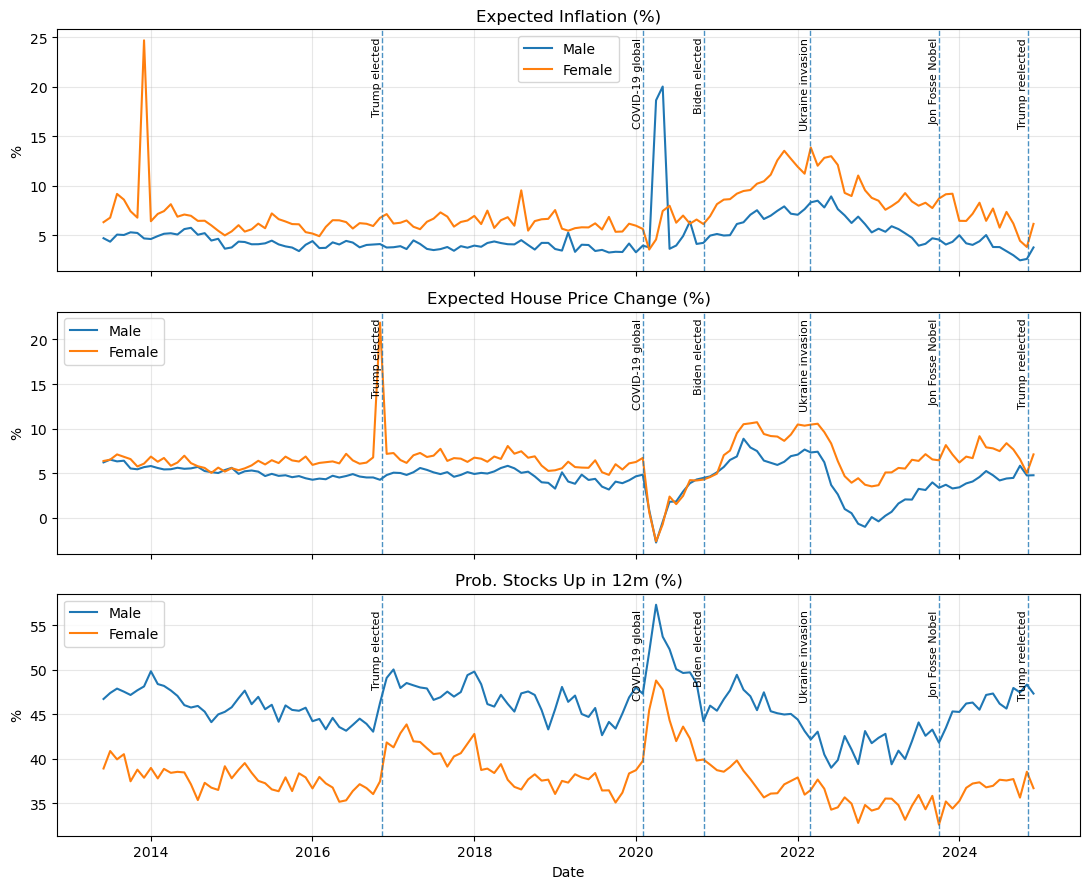

KeyError: 'college'

In [ ]:
import matplotlib.pyplot as plt

# --- Ensure we have a proper 'date' column (not just an index)
if 'date' not in sce_df.columns:
    # if the index is the date, bring it back as a column
    sce_df = sce_df.reset_index()  # will create a 'date' column if index name was 'date'
sce_df['date'] = pd.to_datetime(sce_df['date'])

# --- Monthly averages for a given group variable
def monthly_group_avg(df, group_var):
    df2 = df.copy()
    df2['date'] = pd.to_datetime(df2['date'])
    return (
        df2.groupby([group_var, pd.Grouper(key='date', freq='MS')])  # Month Start
           [['inflation', 'house_price_change', 'prob_stocks_up']]
           .mean()
           .reset_index()
           .sort_values(['date', group_var])
    )

# --- Plot 3 stacked panels with event markers
def plot_expectation_dynamics(df, group_var, labels):
    fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)
    vars_  = ['inflation', 'house_price_change', 'prob_stocks_up']
    titles = ['Expected Inflation (%)',
              'Expected House Price Change (%)',
              'Prob. Stocks Up in 12m (%)']

    for i, var in enumerate(vars_):
        ax = axes[i]
        for val, lab in labels.items():
            sub = df[df[group_var] == val]
            ax.plot(sub['date'], sub[var], label=lab)
        ax.set_title(titles[i])
        ax.set_ylabel('%')
        ax.grid(True, alpha=0.3)
        ax.legend()

    events = [
        ('2016-11-08', 'Trump elected'),
        ('2020-02-01', 'COVID-19 global'),
        ('2020-11-03', 'Biden elected'),
        ('2022-02-24', 'Ukraine invasion'),
        ('2023-10-03', 'Jon Fosse Nobel'),
        ('2024-11-05', 'Trump reelected'),
    ]
    for datestr, lab in events:
        x = pd.to_datetime(datestr)
        for ax in axes:
            ax.axvline(x, linestyle='--', linewidth=1, alpha=0.8)
            ymax = ax.get_ylim()[1]
            ax.text(x, ymax*0.97, lab, rotation=90, va='top', ha='right', fontsize=8)

    axes[-1].set_xlabel('Date')
    fig.tight_layout()
    plt.show()

# --- Calls
monthly_gender  = monthly_group_avg(sce_df, 'female')
plot_expectation_dynamics(monthly_gender, 'female', {0: 'Male', 1: 'Female'})

monthly_college = monthly_group_avg(sce_df, 'college')
plot_expectation_dynamics(monthly_college, 'college', {0: 'Non-College', 1: 'College'})

monthly_numlit  = monthly_group_avg(sce_df, 'num_lit_high')
plot_expectation_dynamics(monthly_numlit, 'num_lit_high', {0: 'Low Numeracy', 1: 'High Numeracy'})
